In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as geom
from scipy.ndimage import gaussian_filter

import libpysal as ps
from esda.moran import Moran

In [15]:
  # PHASE 1: Generate census GeoDataFrame
random_seed = 123
grid_side_length = 3


# Set the random seed for reproducibility
np.random.seed(random_seed)  

# Generate census GeoDataFrame

total_counties = grid_side_length ** 2

# for each county, generate a random number of census tracts from [2,3,4,5,6,7,8]
grid_size_census = np.random.choice([2,3,4,5,6,7,8], total_counties)

# loop through each county and generate the census tracts
df = pd.DataFrame()

for county_index in range(total_counties):

    print(f"Generating census tracts for county {county_index}")

    num_tracts = grid_size_census[county_index]**2

    print(f"Number of tracts: {num_tracts}, grid side length: {grid_size_census[county_index]}")

    lambda_vals = np.random.normal(loc=0.5, scale=0.125, size=num_tracts)

    # Multiply by E = 20
    lambda_vals *= 20
    lambda_vals = np.clip(lambda_vals, a_min=0, a_max=None)

    # Generate Poisson counts for each lambda
    poisson_counts = np.array([np.random.poisson(lam) for lam in lambda_vals])

    # Apply Gaussian smoothing to introduce some positive spatial autocorrelation
    poisson_counts = gaussian_filter(poisson_counts, sigma=1.5)

    # assign Index_county and  poissons_counts to the dataframe
    df_temp = pd.DataFrame({'Index_census':[i for i in range(num_tracts)],'Index_county': [county_index] * num_tracts, 'Rate_cen': poisson_counts})

    

    # Function to calculate square coordinates
    def calculate_square_coordinates(row):
        value = row['Index_census']
        x = value % grid_size_census[county_index]
        y = value // grid_size_census[county_index]
        return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])
    
    # Convert to GeoDataFrame with square geometries
    df_temp['geometry'] = df_temp.apply(calculate_square_coordinates, axis=1)
    gdf_census = gpd.GeoDataFrame(df_temp, geometry='geometry')

    # Append to the main dataframe
    df = pd.concat([df, gdf_census], ignore_index=True)


Generating census tracts for county 0
Number of tracts: 64, grid side length: 8
Generating census tracts for county 1
Number of tracts: 49, grid side length: 7
Generating census tracts for county 2
Number of tracts: 64, grid side length: 8
Generating census tracts for county 3
Number of tracts: 16, grid side length: 4
Generating census tracts for county 4
Number of tracts: 36, grid side length: 6
Generating census tracts for county 5
Number of tracts: 16, grid side length: 4
Generating census tracts for county 6
Number of tracts: 64, grid side length: 8
Generating census tracts for county 7
Number of tracts: 9, grid side length: 3
Generating census tracts for county 8
Number of tracts: 25, grid side length: 5


In [16]:
df.head(10)

,Index_census,Index_county,Rate_cen,geometry
0,0,0,9,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))"
1,1,0,9,"POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))"
2,2,0,9,"POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))"
3,3,0,8,"POLYGON ((3 0, 4 0, 4 1, 3 1, 3 0))"
4,4,0,8,"POLYGON ((4 0, 5 0, 5 1, 4 1, 4 0))"
5,5,0,8,"POLYGON ((5 0, 6 0, 6 1, 5 1, 5 0))"
6,6,0,9,"POLYGON ((6 0, 7 0, 7 1, 6 1, 6 0))"
7,7,0,10,"POLYGON ((7 0, 8 0, 8 1, 7 1, 7 0))"
8,8,0,10,"POLYGON ((0 1, 1 1, 1 2, 0 2, 0 1))"
9,9,0,10,"POLYGON ((1 1, 2 1, 2 2, 1 2, 1 1))"


In [18]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as geom
from scipy.ndimage import gaussian_filter

# --- Parameters and setup ---
random_seed = 123
grid_side_length = 3  # This defines the number of counties along one side
np.random.seed(random_seed)

total_counties = grid_side_length ** 2

# For each county, randomly choose a census grid size (side length of the square) from these options:
grid_size_census = np.random.choice([2, 3, 4, 5, 6, 7, 8], total_counties)

# Prepare an empty DataFrame to store all census tracts
df = pd.DataFrame()

# Define a helper function to create a square polygon given a tract index and grid size
def calculate_square_coordinates(value, grid_size):
    x = value % grid_size
    y = value // grid_size
    return geom.Polygon([(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)])

# --- Loop over counties ---
for county_index in range(total_counties):
    grid_side = grid_size_census[county_index]
    num_tracts = grid_side ** 2

    print(f"County {county_index}: grid size = {grid_side} x {grid_side} (total tracts: {num_tracts})")

    # Generate lambda values for each tract on the grid
    lambda_vals = np.random.normal(loc=0.5, scale=0.125, size=num_tracts) * 20
    lambda_vals = np.clip(lambda_vals, a_min=0, a_max=None)
    
    # Reshape to a 2D grid to reflect spatial structure
    lambda_grid = lambda_vals.reshape((grid_side, grid_side))
    
    # Sample Poisson counts for each grid cell
    poisson_grid = np.random.poisson(lam=lambda_grid)
    
    # Apply Gaussian smoothing on the 2D grid (sigma controls the smoothing amount)
    smoothed_grid = gaussian_filter(poisson_grid, sigma=1.5)
    
    # Flatten back to 1D so we can add it to the DataFrame
    poisson_counts = smoothed_grid.flatten()
    
    # Create a temporary DataFrame for this county
    df_temp = pd.DataFrame({
        'Index_census': np.arange(num_tracts),
        'Index_county': [county_index] * num_tracts,
        'Rate_cen': poisson_counts
    })
    
    # Compute geometries for each tract based on its 1D index and the grid size
    df_temp['geometry'] = df_temp['Index_census'].apply(lambda v: calculate_square_coordinates(v, grid_side))
    
    # Convert to GeoDataFrame and append to the main DataFrame
    gdf_census = gpd.GeoDataFrame(df_temp, geometry='geometry')
    df = pd.concat([df, gdf_census], ignore_index=True)

# (Optional) See the resulting GeoDataFrame
print(df.head())


County 0: grid size = 8 x 8 (total tracts: 64)
County 1: grid size = 7 x 7 (total tracts: 49)
County 2: grid size = 8 x 8 (total tracts: 64)
County 3: grid size = 4 x 4 (total tracts: 16)
County 4: grid size = 6 x 6 (total tracts: 36)
County 5: grid size = 4 x 4 (total tracts: 16)
County 6: grid size = 8 x 8 (total tracts: 64)
County 7: grid size = 3 x 3 (total tracts: 9)
County 8: grid size = 5 x 5 (total tracts: 25)
   Index_census  Index_county  Rate_cen                             geometry
0             0             0         8  POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))
1             1             0         9  POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))
2             2             0         9  POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))
3             3             0         9  POLYGON ((3 0, 4 0, 4 1, 3 1, 3 0))
4             4             0         8  POLYGON ((4 0, 5 0, 5 1, 4 1, 4 0))


In [44]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as geom
from scipy.ndimage import gaussian_filter

# --- Parameters and setup ---
random_seed = 123
grid_side_length = 3  # Number of counties along one side
np.random.seed(random_seed)

total_counties = grid_side_length ** 2

# For each county, choose a census grid size (side length) from a set of options.
grid_size_census = np.random.choice([2, 3, 4, 5, 6, 7, 8], total_counties)

# Prepare an empty DataFrame to store all census tracts
df = pd.DataFrame()

# Helper function: given a tract index and grid size, return a square polygon
def calculate_square_coordinates(value, grid_size):
    x = value % grid_size
    y = value // grid_size
    return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])

# --- Loop over counties ---
for county_index in range(total_counties):
    grid_side = grid_size_census[county_index]
    num_tracts = grid_side ** 2

    print(f"County {county_index}: grid size = {grid_side} x {grid_side} (total tracts: {num_tracts})")

    # Generate lambda values for each tract and scale them (then clip negatives)
    lambda_vals = np.random.normal(loc=0.5, scale=0.125, size=num_tracts) * 20
    lambda_vals = np.clip(lambda_vals, a_min=0, a_max=None)
    
    # Reshape to a 2D grid to reflect spatial structure
    lambda_grid = lambda_vals.reshape((grid_side, grid_side))
    
    # Sample Poisson counts for each grid cell using the lambda grid
    poisson_grid = np.random.poisson(lam=lambda_grid)
    
    # Apply Gaussian smoothing to the 2D grid
    # smoothed_grid = gaussian_filter(poisson_grid, sigma=1.5)
    
    # ---- Introduce additional county-level noise ----
    # Option 1: Add a single county-level offset to all cells in the county.
    # county_offset = np.random.normal(loc=0, scale=2)  # Adjust the 'scale' to control noise magnitude
    # smoothed_grid = smoothed_grid + county_offset

    # Option 2 (alternative): Add cell-level noise instead of a uniform county offset.
    # Uncomment the following two lines if you prefer to add noise to each cell.
    # noise = np.random.normal(loc=0, scale=1, size=smoothed_grid.shape)
    # smoothed_grid = smoothed_grid + noise

    # # Clip negative values to zero (since negative counts don’t make sense)
    # smoothed_grid = np.clip(smoothed_grid, a_min=0, a_max=None)
    
    # Flatten the 2D grid back into a 1D array for the GeoDataFrame
    poisson_counts = poisson_grid.flatten()
    
    # Build a temporary DataFrame for the current county
    df_temp = pd.DataFrame({
        'Index_census': np.arange(num_tracts),
        'Index_county': [county_index] * num_tracts,
        'Rate_cen': poisson_counts
    })
    
    # Compute square geometries for each census tract
    df_temp['geometry'] = df_temp['Index_census'].apply(lambda v: calculate_square_coordinates(v, grid_side))
    gdf_census = gpd.GeoDataFrame(df_temp, geometry='geometry')
    
    # Append the county GeoDataFrame to the main DataFrame
    df = pd.concat([df, gdf_census], ignore_index=True)

# Optional: Display the first few rows of the resulting GeoDataFrame
print(df.head())


County 0: grid size = 8 x 8 (total tracts: 64)
County 1: grid size = 7 x 7 (total tracts: 49)
County 2: grid size = 8 x 8 (total tracts: 64)
County 3: grid size = 4 x 4 (total tracts: 16)
County 4: grid size = 6 x 6 (total tracts: 36)
County 5: grid size = 4 x 4 (total tracts: 16)
County 6: grid size = 8 x 8 (total tracts: 64)
County 7: grid size = 3 x 3 (total tracts: 9)
County 8: grid size = 5 x 5 (total tracts: 25)
   Index_census  Index_county  Rate_cen                             geometry
0             0             0        10  POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))
1             1             0         7  POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))
2             2             0        16  POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))
3             3             0         4  POLYGON ((3 0, 4 0, 4 1, 3 1, 3 0))
4             4             0         7  POLYGON ((4 0, 5 0, 5 1, 4 1, 4 0))


In [45]:
df[df['Index_county'] == 1]

,Index_census,Index_county,Rate_cen,geometry
64,0,1,12,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))"
65,1,1,6,"POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))"
66,2,1,8,"POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))"
67,3,1,4,"POLYGON ((3 0, 4 0, 4 1, 3 1, 3 0))"
68,4,1,14,"POLYGON ((4 0, 5 0, 5 1, 4 1, 4 0))"
69,5,1,12,"POLYGON ((5 0, 6 0, 6 1, 5 1, 5 0))"
70,6,1,13,"POLYGON ((6 0, 7 0, 7 1, 6 1, 6 0))"
71,7,1,10,"POLYGON ((0 1, 1 1, 1 2, 0 2, 0 1))"
72,8,1,4,"POLYGON ((1 1, 2 1, 2 2, 1 2, 1 1))"
73,9,1,16,"POLYGON ((2 1, 3 1, 3 2, 2 2, 2 1))"


County 0: grid size = 8 x 8 (tracts: 64)
Mean: 10.1875
Variance: 10.313492063492063
Skewness: -0.14242630905595777
Kurtosis: -0.02852062330915217
County 1: grid size = 7 x 7 (tracts: 49)
Mean: 10.795918367346939
Variance: 10.749149659863946
Skewness: 0.846994296986802
Kurtosis: 0.5345151263185657
County 2: grid size = 8 x 8 (tracts: 64)
Mean: 9.4375
Variance: 10.948412698412698
Skewness: -0.10070612510859442
Kurtosis: -0.6230682898475988
County 3: grid size = 4 x 4 (tracts: 16)
Mean: 11.5
Variance: 14.4
Skewness: 0.7863865080842002
Kurtosis: -0.8128985212318547
County 4: grid size = 6 x 6 (tracts: 36)
Mean: 10.083333333333334
Variance: 8.078571428571427
Skewness: 0.24280598252183952
Kurtosis: -0.03554209686749532
County 5: grid size = 4 x 4 (tracts: 16)
Mean: 10.375
Variance: 20.783333333333335
Skewness: 0.2817983570366359
Kurtosis: -0.43039643479255085
County 6: grid size = 8 x 8 (tracts: 64)
Mean: 9.90625
Variance: 9.546626984126984
Skewness: 0.20064530420690518
Kurtosis: -0.81312669

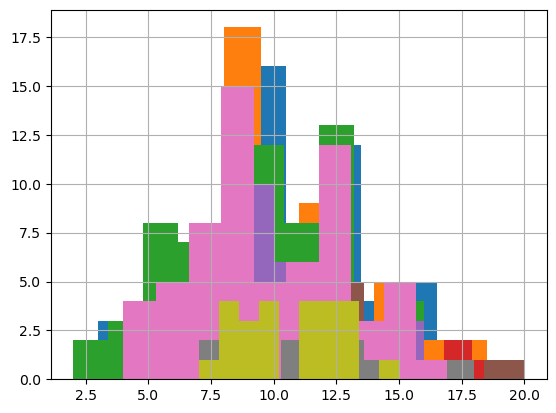

In [52]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as geom
from scipy.ndimage import gaussian_filter

# Parameters and setup
random_seed = 123
grid_side_length = 3  # number of counties along one side
np.random.seed(random_seed)

total_counties = grid_side_length ** 2
# For each county, choose a census grid size (side length) from a set of options.
grid_size_census = np.random.choice([2, 3, 4, 5, 6, 7, 8], total_counties)
df = pd.DataFrame()

def calculate_square_coordinates(value, grid_size):
    x = value % grid_size
    y = value // grid_size
    return geom.Polygon([(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)])

for county_index in range(total_counties):
    grid_side = grid_size_census[county_index]
    num_tracts = grid_side ** 2
    print(f"County {county_index}: grid size = {grid_side} x {grid_side} (tracts: {num_tracts})")

    # Generate the underlying λ values on a grid and scale them
    lambda_grid = np.random.normal(loc=0.5, scale=0.125, size=(grid_side, grid_side)) * 20
    lambda_grid = np.clip(lambda_grid, a_min=0, a_max=None)
    
    # Apply Gaussian smoothing to the λ field to introduce spatial autocorrelation
    smoothed_lambda = gaussian_filter(lambda_grid, sigma=1.5)
    
    # Now sample Poisson counts using the smoothed rate field
    poisson_grid = np.random.poisson(lam=smoothed_lambda)
    poisson_counts = poisson_grid.flatten()
    
    df_temp = pd.DataFrame({
        'Index_census': np.arange(num_tracts),
        'Index_county': [county_index] * num_tracts,
        'Rate_cen': poisson_counts
    })
    
    df_temp['geometry'] = df_temp['Index_census'].apply(lambda v: calculate_square_coordinates(v, grid_side))
    gdf_census = gpd.GeoDataFrame(df_temp, geometry='geometry')

    # plot the histogram of the poisson counts
    gdf_census['Rate_cen'].hist()

    # check for it follows a poisson distribution
    print('Mean:', gdf_census['Rate_cen'].mean())
    print('Variance:', gdf_census['Rate_cen'].var())
    print('Skewness:', gdf_census['Rate_cen'].skew())
    print('Kurtosis:', gdf_census['Rate_cen'].kurtosis())

    
    df = pd.concat([df, gdf_census], ignore_index=True)

print(df.head())


652
County 0 has 64 census tracts and a total deaths of 652
529
County 1 has 49 census tracts and a total deaths of 529
604
County 2 has 64 census tracts and a total deaths of 604
184
County 3 has 16 census tracts and a total deaths of 184


/Users/h6x/anaconda3/envs/pymc_env/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/h6x/anaconda3/envs/pymc_env/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/h6x/anaconda3/envs/pymc_env/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the

363
County 4 has 36 census tracts and a total deaths of 363
166
County 5 has 16 census tracts and a total deaths of 166
634
County 6 has 64 census tracts and a total deaths of 634
107
County 7 has 9 census tracts and a total deaths of 107
265
County 8 has 25 census tracts and a total deaths of 265


/Users/h6x/anaconda3/envs/pymc_env/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/h6x/anaconda3/envs/pymc_env/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/h6x/anaconda3/envs/pymc_env/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the

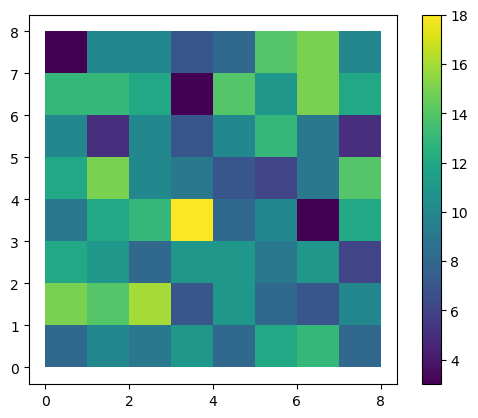

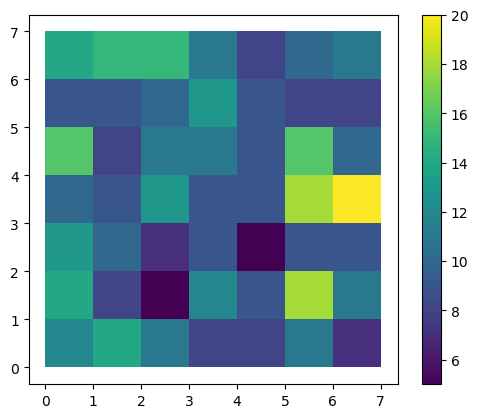

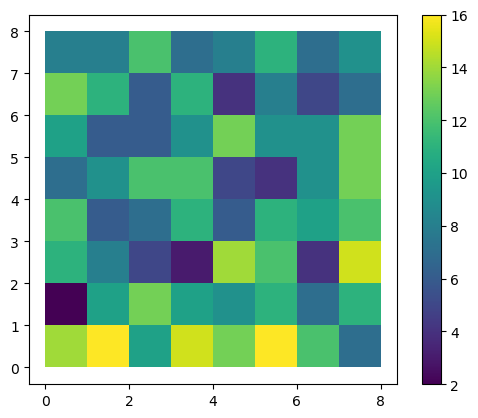

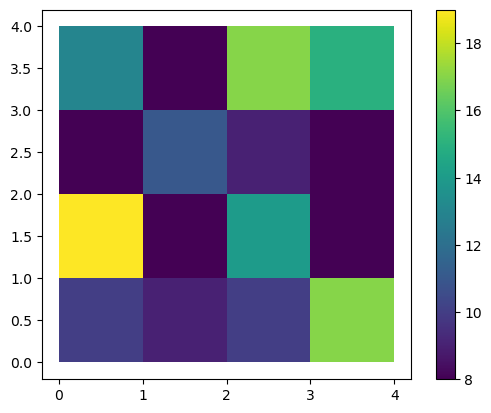

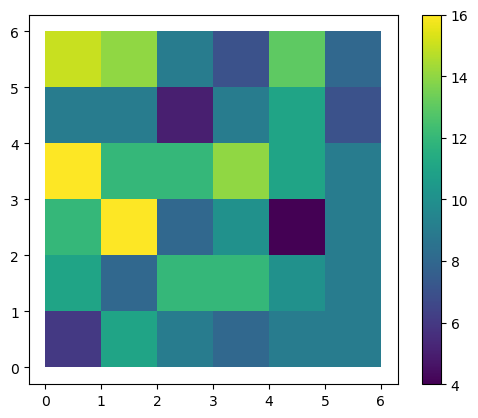

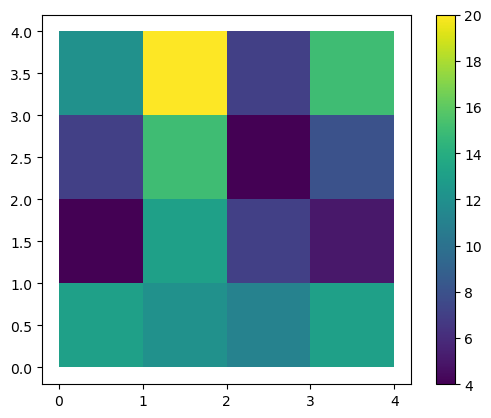

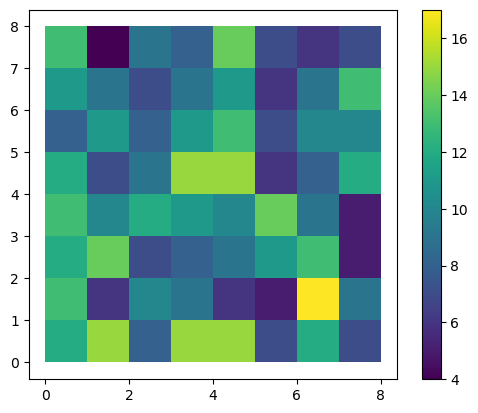

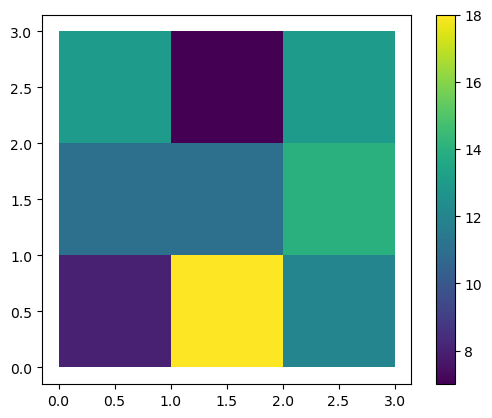

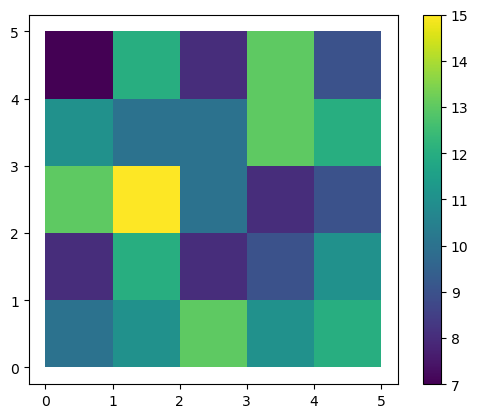

In [53]:
for i in range(grid_side_length**2):
    
    temp = df[df['Index_county'] == i]
    print(temp['Rate_cen'].sum())

    print(f"County {i} has {len(df[df['Index_county'] == i])} census tracts and a total deaths of {df[df['Index_county'] == i]['Rate_cen'].sum()}")

    # make it a geodataframe
    temp = gpd.GeoDataFrame(temp, geometry='geometry')
    temp.crs = {'init': 'epsg:4326'}
    
    # plot the census tracts
    temp.plot(column='Rate_cen', legend=True)
    